In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import xml.etree.ElementTree as ET
from xml.dom import minidom
import json


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.50)))


In [5]:
# Imagem de exemplo

image = cv2.imread('DJI_0128.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


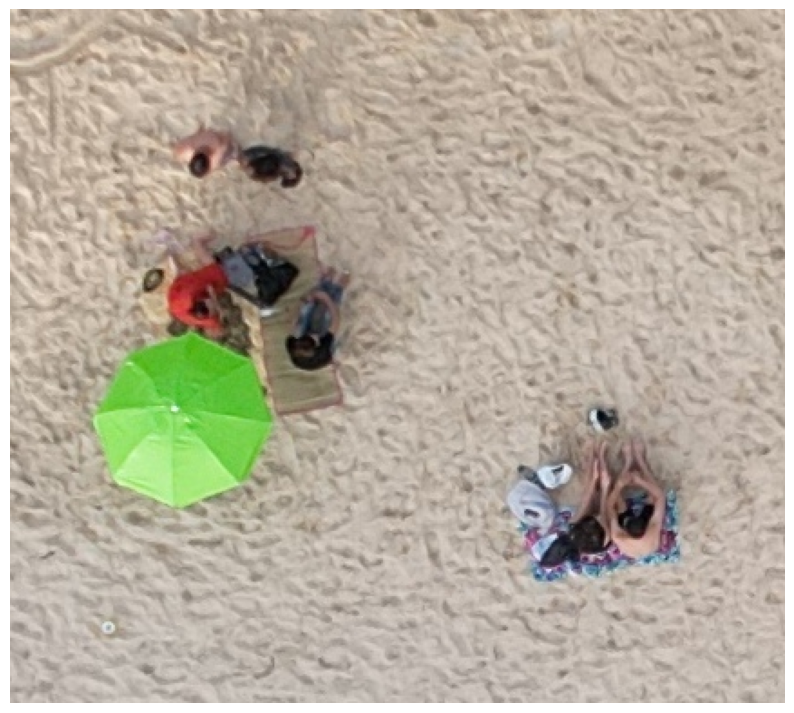

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [3]:
# modelo

sam = sam_model_registry["vit_h"](
    checkpoint="/Users/jac/Documents/projs/sam_vit_h_4b8939.pth")
# device = "cuda"
# sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)


In [6]:
# gerar máscaras utilizando o modelo

masks = mask_generator.generate(image)


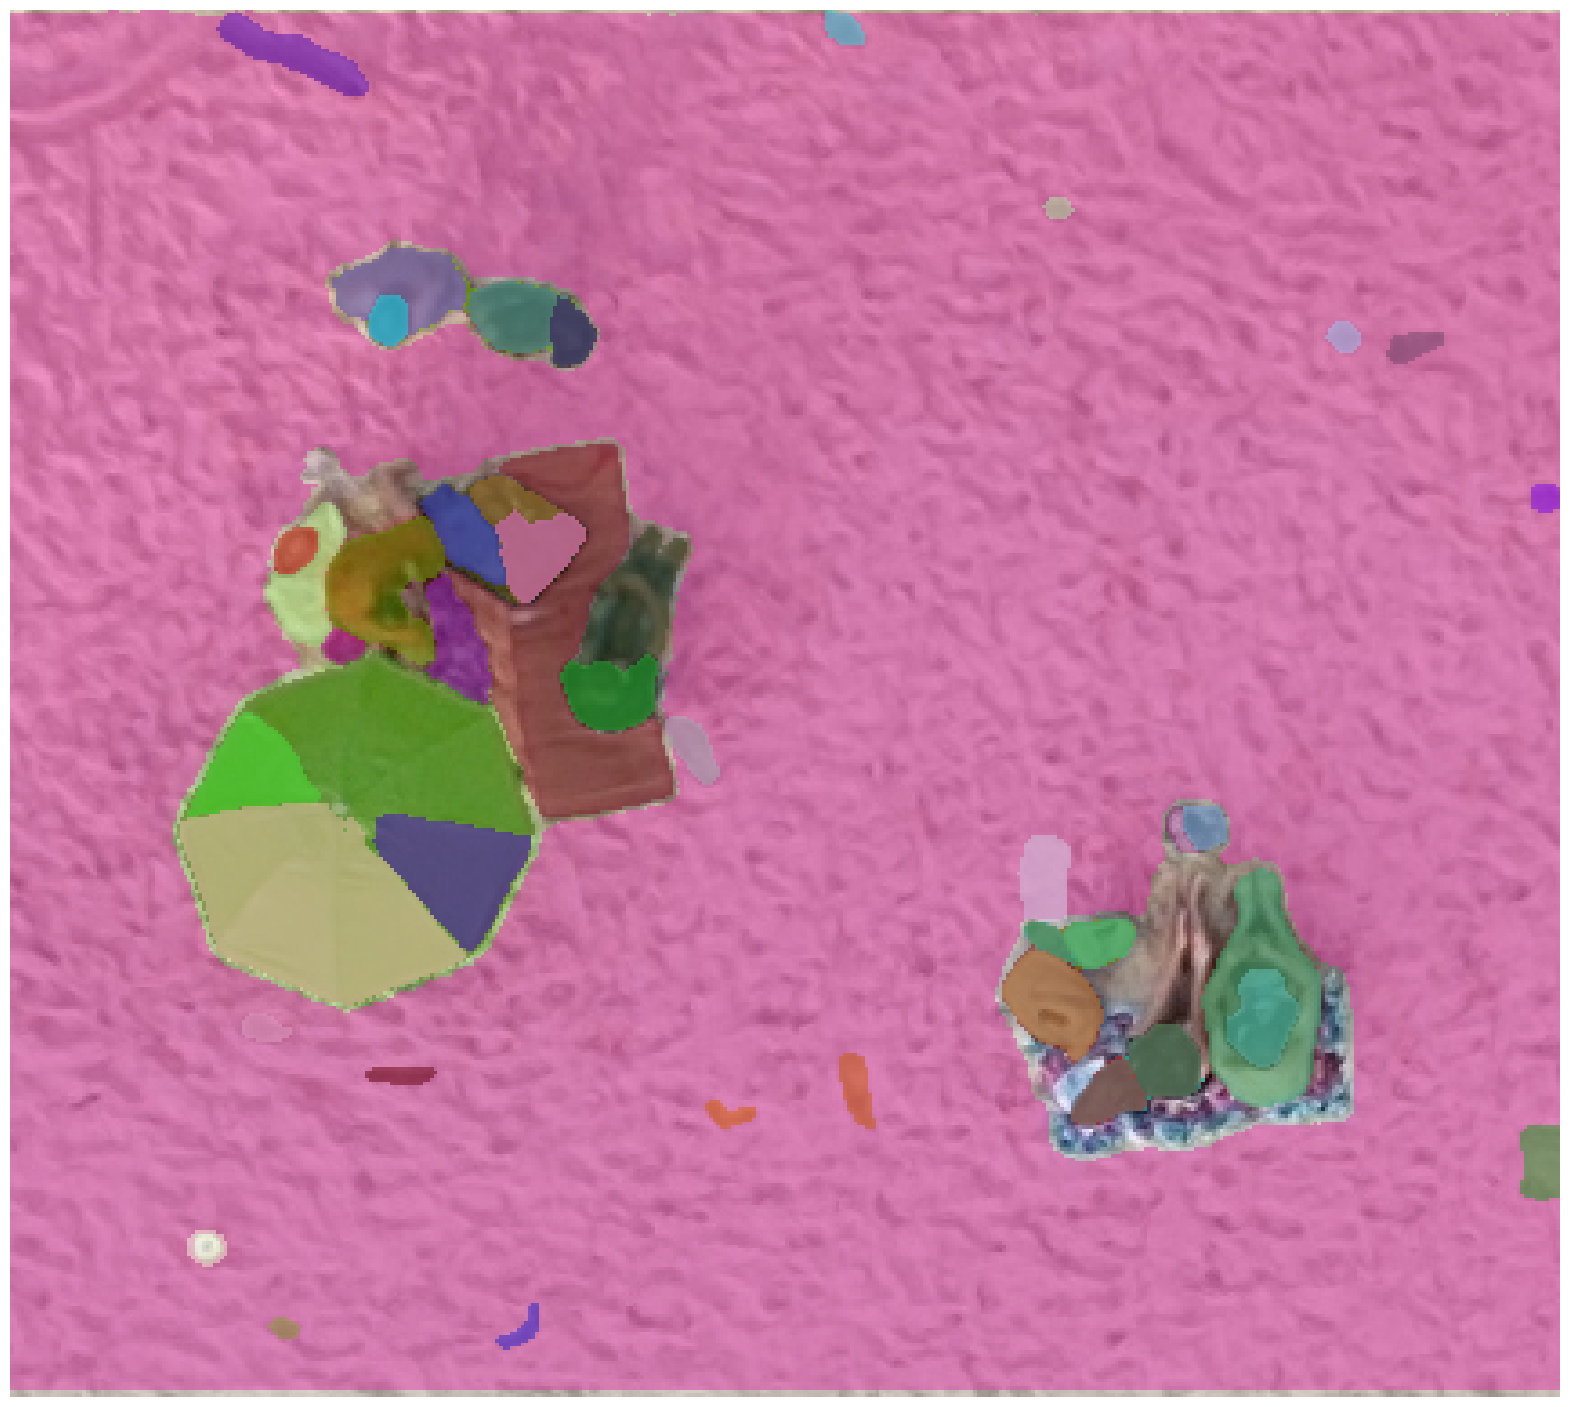

In [19]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


[139317, 6880, 2817, 2645, 1501, 1261, 1106, 1001, 953, 877]


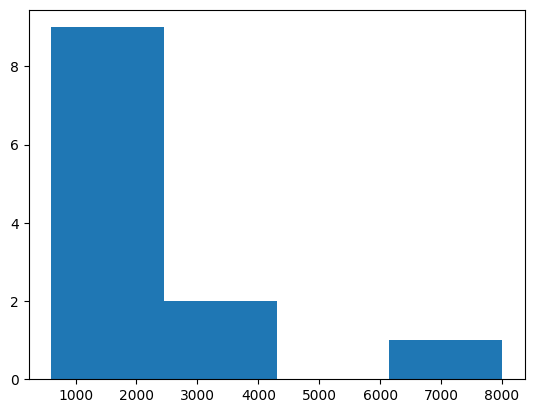

In [8]:
# agrupar as máscaras por tamanho

sizes = [ann['area'] for ann in masks]
sizes.sort(reverse=True)
print(sizes[:10])

bins = np.linspace(600, 8000, 5)
plt.hist(sizes, bins=bins)
plt.show()


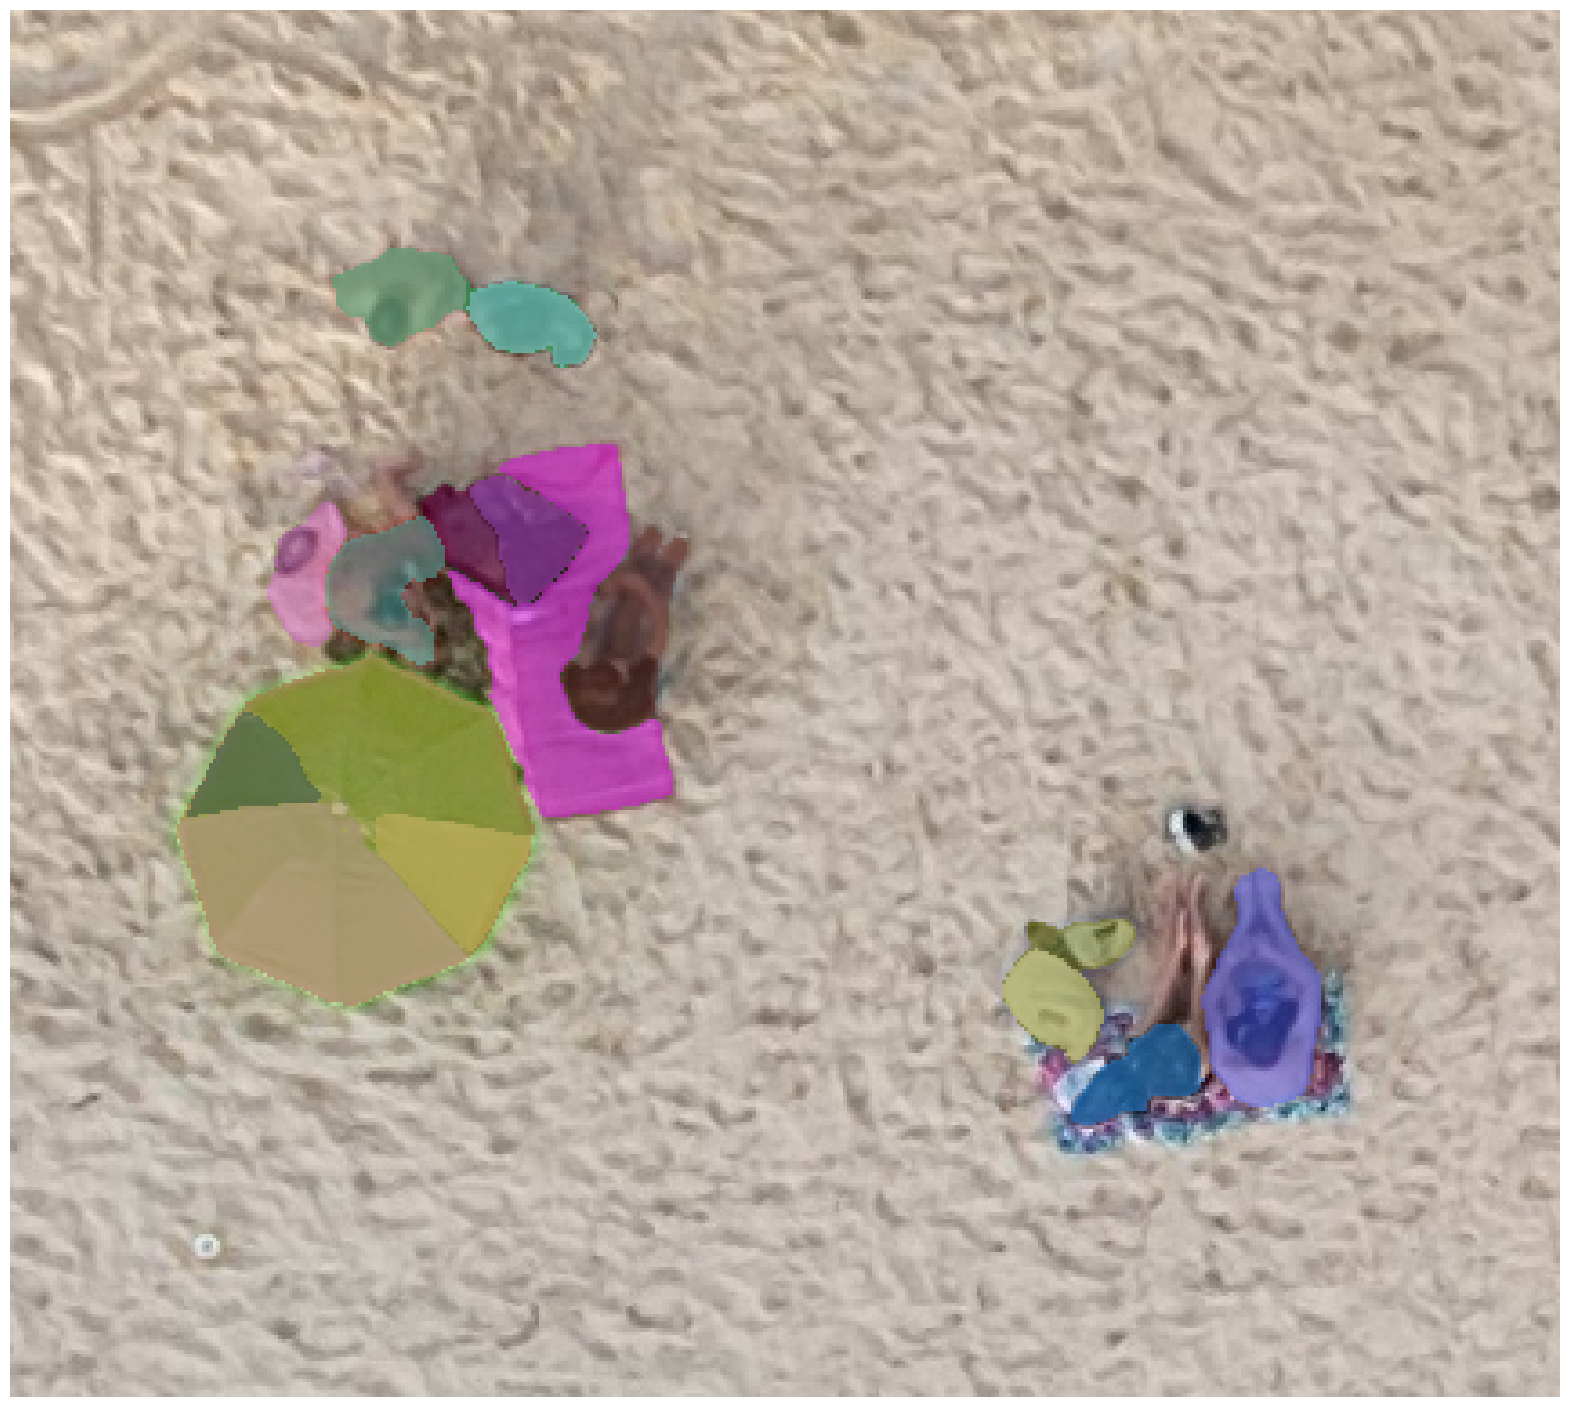

In [19]:
# filtre as máscaras com base no tamanho

masks_filtradas = [ann for ann in masks if (ann['area'] > 500) & (ann['area'] < 10000)]

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks_filtradas)
plt.axis('off')
plt.show()

In [22]:
# salvar cada elemento em uma imagem separada

# for i, mask in enumerate(masks):
#    x, y, w, h = mask['bbox']
#    crop = image[y:y+h, x:x+w]
#    cv2.imwrite(f"objetos/mask_{i}.png", crop)


In [23]:
# salvar as máscaras como xml, para serem usadas no labelimg

def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")


root = ET.Element("annotation")

ET.SubElement(root, "folder").text = "images"
ET.SubElement(root, "filename").text = "DJI_0128.JPG"
ET.SubElement(root, "path").text = "DJI_0128.JPG"

source = ET.SubElement(root, "source")
ET.SubElement(source, "database").text = "Unknown"

size = ET.SubElement(root, "size")
ET.SubElement(size, "width").text = str(image.shape[1])
ET.SubElement(size, "height").text = str(image.shape[0])
ET.SubElement(size, "depth").text = str(image.shape[2])

ET.SubElement(root, "segmented").text = "0"

for i, masks_filtradas in enumerate(masks_filtradas):
    x, y, w, h = masks_filtradas['bbox']
    obj = ET.SubElement(root, "object")
    ET.SubElement(obj, "name").text = "objeto"
    ET.SubElement(obj, "pose").text = "Unspecified"
    ET.SubElement(obj, "truncated").text = "0"
    ET.SubElement(obj, "difficult").text = "0"
    bndbox = ET.SubElement(obj, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(x)
    ET.SubElement(bndbox, "ymin").text = str(y)
    ET.SubElement(bndbox, "xmax").text = str(x+w)
    ET.SubElement(bndbox, "ymax").text = str(y+h)

tree = ET.ElementTree(root)
tree.write("DJI_0128.xml")


In [16]:
# exportar para labelme

labelme = {
    "version": "4.5.6",
    "flags": {},
    "shapes": [],
    "imagePath": "DJI_0128.JPG",
    "imageData": None,
    "imageHeight": image.shape[0],
    "imageWidth": image.shape[1]
}

for i, masks_filtradas in enumerate(masks_filtradas):
    x, y, w, h = masks_filtradas['bbox']
    labelme['shapes'].append({
        "label": "objeto",
        "points": [[x, y], [x+w, y+h]],
        "group_id": None,
        "shape_type": "rectangle",
        "flags": {}
    })

with open('DJI_0128.json', 'w') as fp:
    json.dump(labelme, fp)
    

In [20]:
# exportar para roboflow

roboflow = {
    "DJI_0128.JPG": {
        "fileref": "",
        "size": image.shape[0],
        "filename": "DJI_0128.JPG",
        "base64_img_data": "",
        "file_attributes": {},
        "regions": {}
    }
}

for i, masks_filtradas in enumerate(masks_filtradas):
    x, y, w, h = masks_filtradas['bbox']
    roboflow['DJI_0128.JPG']['regions'][i] = {
        "shape_attributes": {
            "name": "rect",
            "x": x,
            "y": y,
            "width": w,
            "height": h
        },
        "region_attributes": {
            "name": "objeto"
        }
    }

with open('DJI_0128.json', 'w') as fp:
    json.dump(roboflow, fp)

    